# I/O

> input/output management

In [ ]:
#| default_exp io

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from typing import Any

from fastai.vision.all import *
from fastai.data.all import *
from torchio import ScalarImage, ToCanonical, Resample
from aicsimageio import AICSImage
from aicsimageio.writers.writer import Writer as writer
import h5py
import numpy as np

from bioMONAI.core import torchTensor, torch_from_numpy, L

---

### ScalarImage

>      ScalarImage (*args, **kwargs)

Image whose pixel values represent scalars.

See :class:`~torchio.Image` for more information.

## Image Writers

In [ ]:
#| export

def write_image(data, file_path, dimension_order="TCZYX"):
    """
    Writes an image to a file.

    :param data: Image data (numpy array, tensor, or AICSImage)
    :param file_path: Path to save the image
    :param format: Format to save the image in (default is png)
    """
    if isinstance(data, torchTensor):
        data = data.numpy()
    elif isinstance(data, AICSImage):
        data = data.data

    if not isinstance(data, np.ndarray):
        raise ValueError("Unsupported data type. Expected numpy array, tensor, or AICSImage.")

    try:
        # file_path = file_path + '.' + format
        writer.save(data, file_path, dimension_order)
        print(f"Image successfully saved to {file_path}")
    except Exception as e:
        print(f"An error occurred while saving the image: {e}")


In [ ]:

# Example usage:
numpy_array = np.random.rand(3, 100, 100)
write_image(numpy_array, './data_examples/output_from_numpy.tiff')

tensor = torch.rand(3, 100, 100)
write_image(tensor, './data_examples/output_from_tensor.tiff')

aics_image = AICSImage('./data_examples/example_tiff.tiff')
write_image(aics_image, './data_examples/output_from_tiff.png')

Image successfully saved to ./data_examples/output_from_numpy.tiff
Image successfully saved to ./data_examples/output_from_tensor.tiff
Image successfully saved to ./data_examples/output_from_tiff.png


## Image Readers

It uses helper functions such as _load_and_preprocess and _multi_sequence to load and preprocess biological images.

In [ ]:
#| export
def tiff2torch(file_path: str):
    '''
    Load tiff into pytorch tensor
    '''
    import tifffile as tiff
    
    img = np.array(tiff.imread(file_path))
    return torch_from_numpy(img)

In [ ]:
#| export
def string2dict(input_string:str):
    # Create an empty dictionary
    result_dict = {}

    # Iterate over each character in the string
    for char in input_string:
        # Check if the character is a letter (assuming ASCII letters)
        if char.isalpha():
            # Assign the letter as a key and initialize its value to 0
            result_dict[char] = None

    # Now, iterate over each character again to assign numeric values
    for i, char in enumerate(input_string):
        if char.isdigit():
            # Find the corresponding letter (key) for this number (value)
            key = next((k for k, v in result_dict.items() if v is None), None)
            if key is not None:
                # Assign the numeric value to the found key
                result_dict[key] = int(char)
                
    return result_dict

In [ ]:
#| export
def split_path(file_path, # The path to the file to split
                   exts:(L, list)=['.ome.tiff', '.tiff', '.tif', '.png'] # List of filename extensions 
                   ):
    img_ext = [ext for ext in exts if ext in file_path]
    if img_ext == []:
        return file_path, dict()
    p = file_path.split(img_ext[0])
    if len(p) == 1 or p[1] == '':
        return file_path, dict()
    else:
        path = p[0] + img_ext[0]
        ind_dict = string2dict(p[1])
    return path, ind_dict

In [ ]:
#| export
class aics_image_reader():
    def __init__(self,
                 ind_dict=None, # Dictionary indicating the channels to load
                ):
        store_attr()

    def __call__(self, path) -> Any:
        return self.reader(path)
    
    def reader(self, 
               path, # The file path to the image             
               ):

        """
        Reads an image from the specified path using AICSImage library.

        Parameters:
            path (str): The file path to the image.

        Returns:
            tuple: A tuple containing the image data and its affine transformation matrix.
                The image data is a NumPy array representing the image.
                The affine transformation matrix is a 4x4 NumPy array.
        """

        ind_dict = self.ind_dict
        if ind_dict == None:
            # parse path string
            path, ind_dict = split_path(str(path))
        # Read image using AICSImage library
        image_aics = AICSImage(path, reconstruct_mosaic=False)
            
        # Support for tiff files    
        path = str(path)
        if (path[-4:]=="tiff" or path[-3:]=="tif"):
            # Reorder for tiff files
            data = image_aics.get_image_data("CZYX", **ind_dict)  # returns 4D CZYX numpy array
            affine = np.eye(4) 
            return data, affine
        
        if (path[-3:]=="png"):
            # Reorder for png files
            data = image_aics.get_image_data("SZYX", **ind_dict)  # returns 4D CZYX numpy array        
            affine = np.eye(4)         
            return data, affine

        # Convert to numpy array    
        data = image_aics.data
        # Remove singleton dimensions
        data = np.squeeze(data)
        # Create an identity affine transformation matrix
        affine = np.eye(4)
        # Return the image data and the affine matrix
        return data, affine


In [ ]:
file_path = 'data_examples/example_tiff.tiff'
test_img, _ = aics_image_reader({'Z': 0})(file_path)
test_img.shape

(1, 1, 512, 512)

### Hierarchical Data Format

In [ ]:
#| export
def split_hdf_path(file_path, # The path to the HDF5 file to split
                   hdf5_exts:(L, list)=['.h5','.hdf5'] # List of filename extensions 
                   ):
    hdf5_ext = [ext for ext in hdf5_exts if ext in file_path][0]
    if hdf5_ext == []:
        return file_path, None, None
    p = file_path.split(hdf5_ext)
    if len(p) == 1 or p[1] == '':
        return file_path, None, None
    else:
        path = p[0] + hdf5_ext
        dataset, patch = p[1].split('/')[1:]
        patch = int(patch)
    return path, dataset, patch

In [ ]:
#| export
class hdf5_reader():
    def __init__(self,
                 dataset=None, # The dataset to load
                 patch=0, # The patch to load from the dataset
                 hdf5_exts:(L, list)=['.h5','.hdf5'], # List of filename extensions 
                ):
        store_attr()

    def __call__(self, path) -> Any:
        return self.reader(path)
    
    def reader(self, 
               path, # The path to the HDF5 file to be read
               ):
        """
        Reads a *.h5 (HDF5 format) file and returns the image data along with an identity affine matrix.

        Parameters:
        path (str): The path to the file to be read.

        Returns:
        tuple: A tuple containing:
            - data (numpy.ndarray): The image data read from the file.
            - affine (numpy.ndarray): A 4x4 identity affine matrix.
        """
        
        # split path
        if self.dataset == None:
            path, dataset, patch = split_hdf_path(path, self.hdf5_exts)
            self.dataset = dataset
            self.patch = patch

        with h5py.File(path, 'r') as file:
                if self.dataset == None: print('List of datasets in this file: \n',list(file.keys())); return None
                else:
                    data = file[self.dataset + '/' + '%d'%(self.patch)][:] 

        # Create a 4x4 identity affine NumpyArray
        affine = np.eye(4)

        # Return the image data and the affine matrix
        return data, affine


Images can be loaded by explicitly writing dataset name and path number...

In [ ]:
from bioMONAI.visualize import plot_image


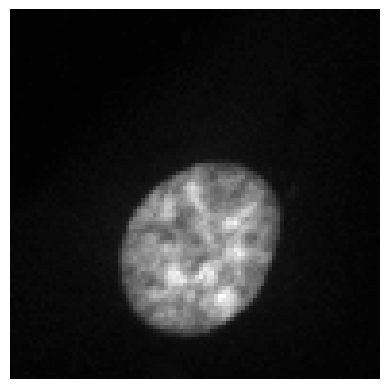

In [ ]:
file_path = './data_examples/0450_1.hdf5'
dataset_name='clean'
patch_num=10

im , _ = hdf5_reader(dataset=dataset_name, patch=patch_num)(file_path)
plot_image(im[0])

... or enconding them in the path, where datasets are subfolders and patches the image files. The latter being compatible with `image_reader` syntaxis.

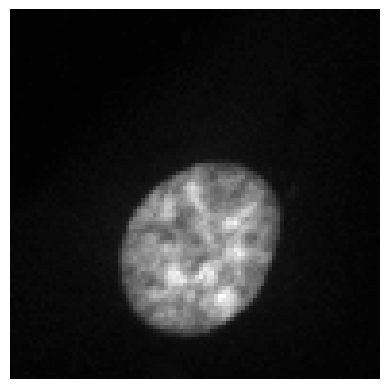

In [ ]:
f = file_path + '/' + dataset_name + '/' + '%d'%(patch_num)
im , _ = hdf5_reader()(f)
plot_image(im[0])

### Preprocessing

In [ ]:
#| export

def _preprocess(obj, # The object to preprocess
                reorder, # Whether to reorder the object
                resample # Whether to resample the object
               ):
    """
    Preprocesses the given object.

    Args:
        obj: The object to preprocess.
        reorder: Whether to reorder the object.
        resample: Whether to resample the object.

    Returns:
        The preprocessed object and its original size.
    """
    if reorder:
        transform = ToCanonical()
        obj = transform(obj)
    
    original_size = obj.shape[1:]

    if resample and not all(np.isclose(obj.spacing, resample)):
        transform = Resample(resample)
        obj = transform(obj)

    return obj, original_size


### Load and preprocess

In [ ]:
#| export
def _load_and_preprocess(file_path, # Image file path
                         reorder=False, # Whether to reorder data for canonical (RAS+) orientation
                         resample=False, # Whether to resample image to different voxel sizes and dimensions
                         reader=None # Image reader
                        ):
    """
    Helper function to load and preprocess an image.

    Args:
        file_path: Image file path.
        reorder: Whether to reorder data for canonical (RAS+) orientation.
        resample: Whether to resample image to different voxel sizes and dimensions.
        dtype: Desired datatype for output.

    Returns:
        tuple: Original image, preprocessed image, and its original size.
    """
    # Check if the file is a .npy file
    if str(file_path).endswith('.npy'):
        # Load the numpy array
        img_data = np.load(file_path)
        
        # Convert the numpy array 
        org_img = ScalarImage(tensor=img_data)
        org_size = img_data.shape
        
        # Apply preprocessing (resampling or reordering) if necessary
        input_img, org_size = _preprocess(org_img, reorder, resample)
        
        return org_img, input_img, org_size

    # If the reader is not specified, choose one based on the file extension
    if reader is None:
        hdf5_ext = [ext for ext in ['.h5','.hdf5'] if ext in str(file_path)]
        if hdf5_ext:
            path, dataset, patch = split_hdf_path(file_path, hdf5_exts=hdf5_ext)
            reader = hdf5_reader(dataset=dataset, patch=patch, hdf5_exts=hdf5_ext)
            file_path = path
        else:
            file_path, ind_dict = split_path(str(file_path))
            reader = aics_image_reader(ind_dict)
    
    # Load the image using the specified reader
    org_img = ScalarImage(file_path, reader=reader)
    input_img, org_size = _preprocess(org_img, reorder, resample)
    
    return org_img, input_img, org_size


In [ ]:
org_img, _, _ = _load_and_preprocess(f)

test_eq(org_img.data[0].shape, im.shape)

### Read multichannel data

In [ ]:
#| export
def _multi_sequence(image_paths: (L, list), # List of image paths (e.g., T1, T2, T1CE, DWI)
                   dtype=torchTensor, # Desired datatype for output
                   only_tensor: bool = True, # Whether to return only image tensor
                   squeeze: bool = False, # 
                   **kwargs, 
                  ):
    """
    Load and preprocess multisequence data.

    Args:
        image_paths: List of image paths (e.g., T1, T2, T1CE, DWI).
        reorder: Whether to reorder data for canonical (RAS+) orientation.
        resample: Whether to resample image to different voxel sizes and dimensions.
        dtype: Desired datatype for output.
        only_tensor: Whether to return only image tensor.
        squeeze: Whether to squeeze or not the image

    Returns:
        torchTensor: A stacked 4D tensor, if `only_tensor` is True.
        tuple: Original image, preprocessed image, original size, if `only_tensor` is False.
    """
    image_data = [_load_and_preprocess(image, **kwargs) for image in image_paths]
    org_img, input_img, org_size = image_data[-1]

    tensor = torch.stack([img.data[0] for _, img, _ in image_data], dim=0)

    if only_tensor:     
        if squeeze:
            return torch.squeeze(dtype(tensor))
        return dtype(tensor) 

    input_img.set_data(tensor)
    return org_img, input_img, org_size

In [ ]:
t = _multi_sequence([f], only_tensor=True);
test_eq(t[0].shape, im.shape)


In [ ]:
t.shape

torch.Size([1, 1, 96, 96])

### Image reader

In [ ]:
#| export

def image_reader(file_path: (str, Path, L, list), # Path to the image
               dtype=torchTensor, # Datatype for the return value. Defaults to torchTensor
               only_tensor: bool = True, # To return only an image tensor
               **kwargs,
              ):
    """Loads and preprocesses a medical image.

    Args:
        file_path: Path to the image. Can be a string, Path object or a list.
        dtype: Datatype for the return value. Defaults to torchTensor.
        reorder: Whether to reorder the data to be closest to canonical 
            (RAS+) orientation. Defaults to False.
        resample: Whether to resample image to different voxel sizes and 
            image dimensions. Defaults to None.
        only_tensor: To return only an image tensor. Defaults to True.

    Returns:
        The preprocessed image. Returns only the image tensor if 
        only_tensor is True, otherwise returns original image, 
        preprocessed image, and original size.
    """
    # if isinstance(file_path, str) and ';' in file_path:
    #     return _multi_channel(
    #         file_path.split(';'), reorder, resample, dtype, only_tensor)
    
    if isinstance(file_path, (L, list)):
        return _multi_sequence(file_path, dtype, only_tensor, **kwargs)

    org_img, input_img, org_size = _load_and_preprocess(file_path, **kwargs)

    if only_tensor:
        return dtype(input_img.data.type(torch.float))

    return org_img, input_img, org_size


In [ ]:
test_eq(image_reader(f)[0].shape, im.shape)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()